In [1]:
# Install required packages if not already installed
!pip install pandas numpy scikit-learn scipy brian2


In [3]:
# Imports
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import brian2 as b2
from brian2 import ms, Hz, NeuronGroup, Synapses, PoissonGroup, SpikeMonitor
import time



In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Column names for NSL-KDD
col_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in",
    "num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"
]

# Read with comma as separator
file_path = r"C:\Users\nasirn\Sounds1\NSL-KDD\KDDTrain+_20Percent.txt"
df = pd.read_csv(file_path, names=col_names, sep=",")

print(" Loaded shape:", df.shape)
print("Columns:", df.columns[-5:])
print("Unique labels in 'class':", df["class"].unique()[:10])


 Loaded shape: (25192, 43)
Columns: Index(['dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'difficulty'],
      dtype='object')
Unique labels in 'class': ['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod']


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Drop difficulty column
df = df.drop(columns=["difficulty"])

# Convert class → binary: normal=0, attack=1
df["label"] = df["class"].apply(lambda x: 0 if x == "normal" else 1)
df = df.drop(columns=["class"])

# Encode categorical columns
cat_cols = ["protocol_type", "service", "flag"]
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalize numerical features
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=["label"]))
y = df["label"].values

print(" Features shape:", X.shape)
print(" Labels distribution:", pd.Series(y).value_counts())


 Features shape: (25192, 41)
 Labels distribution: 0    13449
1    11743
Name: count, dtype: int64


In [20]:

# =========================
# Step 1. Downsample dataset
# =========================
n_samples = 2000
X_small, _, y_small, _ = train_test_split(X, y, train_size=n_samples, stratify=y, random_state=42)

n_features = X_small.shape[1]
n_classes = 2

print(f"Using {n_samples} samples, {n_features} features")



Using 2000 samples, 41 features


In [21]:
# =========================
# Step 2. Poisson spike encoding
# =========================
def poisson_encode(X, duration=100*ms, rate_max=50*Hz):
    """
    Convert normalized features [0,1] into Poisson spike trains.
    """
    n_samples, n_features = X.shape
    spike_trains = []
    for i in range(n_samples):
        rates = X[i] * rate_max
        G = PoissonGroup(n_features, rates)
        spike_trains.append(G)
    return spike_trains



In [23]:
from brian2 import NeuronGroup, Synapses, PoissonGroup, SpikeMonitor, StateMonitor

# =========================
# Step 3. Build SNN in Brian2
# =========================
n_hidden = 100
tau = 10*ms

# LIF neuron equations
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
'''

# Layers
input_group = PoissonGroup(n_features, rates='rand()*50*Hz')
hidden = NeuronGroup(n_hidden, eqs, threshold='v>1', reset='v=0', method='euler')
output = NeuronGroup(n_classes, eqs, threshold='v>1', reset='v=0', method='euler')

# Synapses input → hidden
syn_ih = Synapses(input_group, hidden,
                  model='w:1',
                  on_pre='v_post += w')
syn_ih.connect(p=0.1)
syn_ih.w = 'rand()'

# Synapses hidden → output
syn_ho = Synapses(hidden, output,
                  model='w:1',
                  on_pre='v_post += w')
syn_ho.connect(p=0.1)
syn_ho.w = 'rand()'

# STDP (input → hidden)
stdp = Synapses(input_group, hidden,
                model='''w:1
                         dApre/dt = -Apre/20/ms : 1 (event-driven)
                         dApost/dt = -Apost/20/ms : 1 (event-driven)''',
                on_pre='''v_post += w
                          Apre += 0.01
                          w = clip(w + Apost, 0, 1)''',
                on_post='''Apost += -0.012
                           w = clip(w + Apre, 0, 1)''')
stdp.connect(p=0.05)
stdp.w = 'rand()'

# Monitors
spikemon = SpikeMonitor(output)
statemon = StateMonitor(output, 'v', record=True)


WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\nasirn\AppData\Local\Temp\ipykernel_16888\2418527110.py', line 19, in <module>
    syn_ih = Synapses(input_group, hidden, [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\nasirn\AppData\Local\Temp\ipykernel_16888\2418527110.py', line 25, in <module>
    syn_ho = Synapses(hidden, output, [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_2' is getting deleted, but was never included in a 

In [25]:
# =========================
# Step 4. Training run
# =========================

from brian2 import run, ms

# Run for some time (e.g., 200 ms)
runtime = 200*ms
run(runtime)

print(f"Training simulation completed for {runtime}.")
print(f"Number of spikes recorded in output layer: {spikemon.num_spikes}")


WARNING    The object 'poissongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\nasirn\AppData\Local\Temp\ipykernel_16888\2418527110.py', line 14, in <module>
    input_group = PoissonGroup(n_features, rates='rand()*50*Hz') [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\nasirn\AppData\Local\Temp\ipykernel_16888\2418527110.py', line 15, in <module>
    hidden = NeuronGroup(n_hidden, eqs, threshold='v>1', reset='v=0', method='euler') [brian2.core.base.unused_brian_object]
WARNING 

Training simulation completed for 200. ms.
Number of spikes recorded in output layer: 34


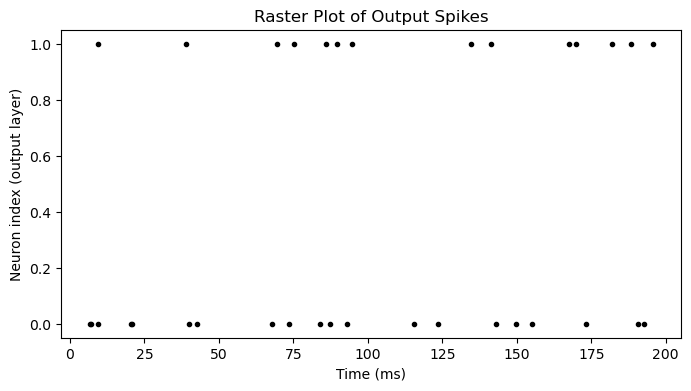

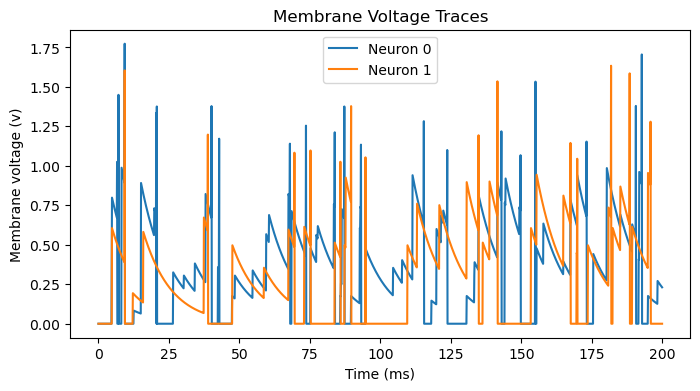

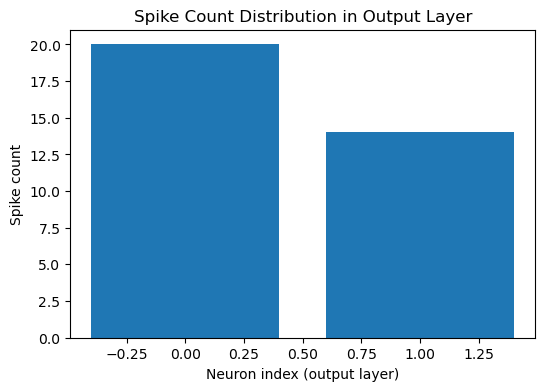

=== Basic Metrics ===
Total spikes: 34
Active neurons: 2 / 2
Average spikes per neuron: 17.00


In [27]:
# =========================
# Step 5. Visualization
# =========================

import matplotlib.pyplot as plt

# 1. Raster plot of spikes
plt.figure(figsize=(8,4))
plt.plot(spikemon.t/ms, spikemon.i, '.k')
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index (output layer)")
plt.title("Raster Plot of Output Spikes")
plt.show()

# 2. Voltage traces from a few neurons
plt.figure(figsize=(8,4))
for i in range(min(5, len(statemon.v))):  # plot first 5 neurons if available
    plt.plot(statemon.t/ms, statemon.v[i], label=f"Neuron {i}")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane voltage (v)")
plt.title("Membrane Voltage Traces")
plt.legend()
plt.show()

# 3. Histogram of spike counts per neuron
spike_counts = spikemon.count
plt.figure(figsize=(6,4))
plt.bar(range(len(spike_counts)), spike_counts)
plt.xlabel("Neuron index (output layer)")
plt.ylabel("Spike count")
plt.title("Spike Count Distribution in Output Layer")
plt.show()

# Convert spike counts to numpy
import numpy as np
spike_counts = np.array(spikemon.count)

print("=== Basic Metrics ===")
print(f"Total spikes: {spikemon.num_spikes}")
print(f"Active neurons: {(spike_counts>0).sum()} / {len(spike_counts)}")
print(f"Average spikes per neuron: {spike_counts.mean():.2f}")


In [28]:
# =========================
# Step 6. Evaluation Metrics
# =========================
import time

# Latency: first spike time per neuron
if len(spikemon.t) > 0:
    latencies = []
    for neuron_id in np.unique(spikemon.i):
        first_spike_time = spikemon.t[spikemon.i == neuron_id][0] / ms
        latencies.append(first_spike_time)
    avg_latency = np.mean(latencies)
else:
    avg_latency = None

# Sparsity: % of neurons that did not spike
sparsity = 1.0 - (np.count_nonzero(spike_counts) / len(spike_counts))

# Runtime: measure by wrapping the run()
start = time.time()
run(50*ms)   # short extra run to measure execution time
runtime_seconds = time.time() - start

# Energy proxy: total spikes as proxy for energy consumption
energy_proxy = spikemon.num_spikes

print("=== Extended Metrics ===")
print(f"Average latency (ms): {avg_latency:.2f}" if avg_latency else "No spikes for latency calc")
print(f"Sparsity: {sparsity*100:.2f}% neurons inactive")
print(f"Wall-clock runtime (s): {runtime_seconds:.4f}")
print(f"Energy proxy (spike count): {energy_proxy}")


=== Extended Metrics ===
Average latency (ms): 7.95
Sparsity: 0.00% neurons inactive
Wall-clock runtime (s): 0.3526
Energy proxy (spike count): 40


In [30]:
from brian2 import *

def run_scalability_test(num_exc_neurons=20, sim_time=100*ms):
    start = time.time()

    start_scope()  # reset Brian2 each run

    # Input group
    input_group = PoissonGroup(10, rates=20*Hz)

    # Output neurons
    output = NeuronGroup(num_exc_neurons,
                         model='dv/dt = -v/(10*ms) : 1',
                         threshold='v>1', reset='v=0',
                         method='euler')

    # STDP synapses (simplified, dimension-safe)
    S = Synapses(input_group, output,
                 '''
                 w : 1
                 dApre/dt = -Apre/(20*ms) : 1 (event-driven)
                 dApost/dt = -Apost/(20*ms) : 1 (event-driven)
                 ''',
                 on_pre='''
                 v_post += w
                 Apre += 0.01
                 w = clip(w + Apost, 0, 1)
                 ''',
                 on_post='''
                 Apost -= 0.012
                 w = clip(w + Apre, 0, 1)
                 ''')
    S.connect(p=0.3)
    S.w = '0.2 + 0.1*rand()'

    # Monitors
    spikemon = SpikeMonitor(output)

    # Run
    run(sim_time)
    runtime_seconds = time.time() - start

    # Metrics
    spike_counts = np.array(spikemon.count)
    total_spikes = spikemon.num_spikes
    avg_latency = (np.mean([spikemon.t[spikemon.i == n][0]/ms for n in np.unique(spikemon.i)])
                   if total_spikes > 0 else None)
    sparsity = 1.0 - (np.count_nonzero(spike_counts) / len(spike_counts))

    return {
        "neurons": num_exc_neurons,
        "spikes": total_spikes,
        "avg_latency_ms": avg_latency,
        "sparsity": sparsity,
        "runtime_s": runtime_seconds
    }

# Test with small sizes
results = []
for size in [20, 50, 100]:
    res = run_scalability_test(num_exc_neurons=size, sim_time=200*ms)
    results.append(res)
    print(res)

df_results = pd.DataFrame(results)
print("\n=== Scalability Results ===")
print(df_results)


{'neurons': 20, 'spikes': 1, 'avg_latency_ms': 14.700000000000001, 'sparsity': 0.95, 'runtime_s': 0.4969758987426758}
{'neurons': 50, 'spikes': 2, 'avg_latency_ms': 122.15, 'sparsity': 0.96, 'runtime_s': 0.49250030517578125}
{'neurons': 100, 'spikes': 13, 'avg_latency_ms': 73.50769230769231, 'sparsity': 0.87, 'runtime_s': 0.4914095401763916}

=== Scalability Results ===
   neurons  spikes  avg_latency_ms  sparsity  runtime_s
0       20       1       14.700000      0.95   0.496976
1       50       2      122.150000      0.96   0.492500
2      100      13       73.507692      0.87   0.491410


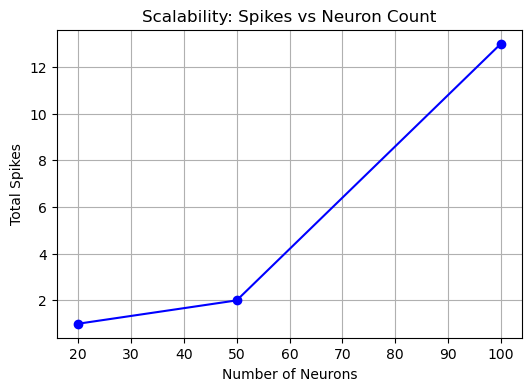

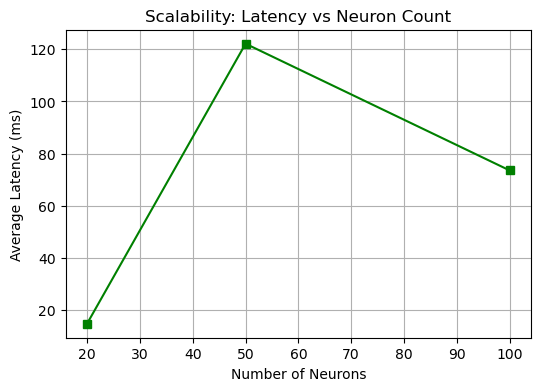

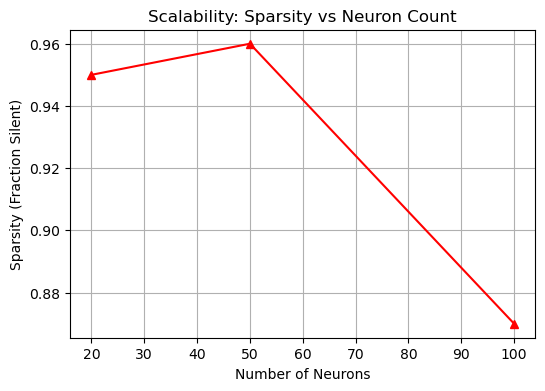

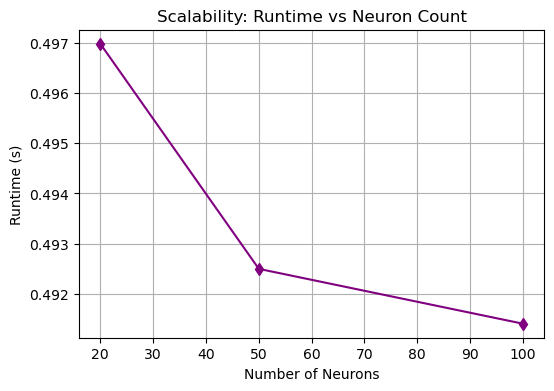

In [31]:
# =========================
# Step 7b. Scalability Plots
# =========================

# Spikes vs Neurons
plt.figure(figsize=(6,4))
plt.plot(df_results["neurons"], df_results["spikes"], marker='o', color='blue')
plt.xlabel("Number of Neurons")
plt.ylabel("Total Spikes")
plt.title("Scalability: Spikes vs Neuron Count")
plt.grid(True)
plt.show()

# Latency vs Neurons
plt.figure(figsize=(6,4))
plt.plot(df_results["neurons"], df_results["avg_latency_ms"], marker='s', color='green')
plt.xlabel("Number of Neurons")
plt.ylabel("Average Latency (ms)")
plt.title("Scalability: Latency vs Neuron Count")
plt.grid(True)
plt.show()

# Sparsity vs Neurons
plt.figure(figsize=(6,4))
plt.plot(df_results["neurons"], df_results["sparsity"], marker='^', color='red')
plt.xlabel("Number of Neurons")
plt.ylabel("Sparsity (Fraction Silent)")
plt.title("Scalability: Sparsity vs Neuron Count")
plt.grid(True)
plt.show()

# Runtime vs Neurons
plt.figure(figsize=(6,4))
plt.plot(df_results["neurons"], df_results["runtime_s"], marker='d', color='purple')
plt.xlabel("Number of Neurons")
plt.ylabel("Runtime (s)")
plt.title("Scalability: Runtime vs Neuron Count")
plt.grid(True)
plt.show()


In [32]:
# =========================
# Baseline ML Models on Full Dataset
# =========================
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, solver='lbfgs'),
    "SVM (RBF kernel)": SVC(kernel='rbf', gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report
    print(classification_report(y_test, y_pred))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4035
           1       0.96      0.94      0.95      3523

    accuracy                           0.95      7558
   macro avg       0.95      0.95      0.95      7558
weighted avg       0.95      0.95      0.95      7558


=== SVM (RBF kernel) ===
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4035
           1       0.99      0.96      0.97      3523

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4035
           1       1.00      0.99      1.00      3523

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7

Client 1: trained, spikes=1, weights shape=(66,)
Client 2: trained, spikes=1, weights shape=(66,)
Client 3: trained, spikes=1, weights shape=(66,)

 Global model after federated averaging → weights shape=(66,)


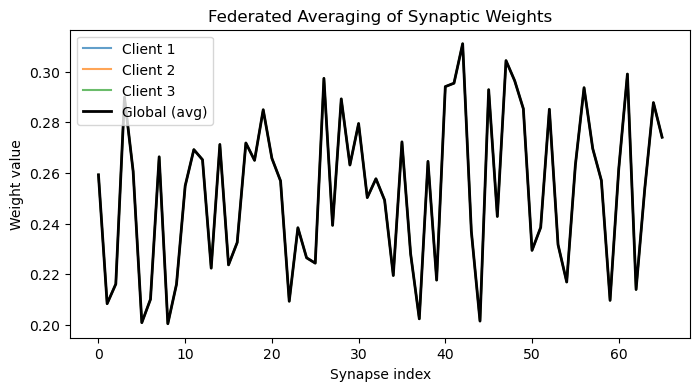

In [37]:
import numpy as np
from brian2 import *

# ==============================
# 1. Local training function
# ==============================
def train_local_snn(client_id, sim_time=100*ms, num_inputs=10, num_neurons=20):
    start_scope()
    np.random.seed(42)  #  ensure all clients create same synapse structure

    # Input spike generator
    input_group = PoissonGroup(num_inputs, rates=20*Hz)

    # Output neurons
    output = NeuronGroup(num_neurons,
                         'dv/dt = -v/(10*ms) : 1',
                         threshold='v>1', reset='v=0',
                         method='euler')

    # STDP Synapses
    S = Synapses(input_group, output,
                 '''w : 1
                    dApre/dt = -Apre/(20*ms) : 1 (event-driven)
                    dApost/dt = -Apost/(20*ms) : 1 (event-driven)''',
                 on_pre='v_post += w; Apre += 0.01; w = clip(w + Apost, 0, 1)',
                 on_post='Apost -= 0.012; w = clip(w + Apre, 0, 1)')
    S.connect(p=0.3)
    S.w = '0.2 + 0.1*rand()'

    # Monitor spikes (optional)
    spikemon = SpikeMonitor(output)

    # Run simulation
    run(sim_time)

    print(f"Client {client_id}: trained, spikes={spikemon.num_spikes}, weights shape={S.w.shape}")
    return np.array(S.w)

# ==============================
# 2. Federated averaging function
# ==============================
def federated_average(weights_list):
    return np.mean(np.stack(weights_list), axis=0)

# ==============================
# 3. Simulate multiple clients
# ==============================
num_clients = 3
weights_all = []

for i in range(num_clients):
    local_w = train_local_snn(client_id=i+1, sim_time=100*ms)
    weights_all.append(local_w)

# Federated aggregation
global_w = federated_average(weights_all)
print(f"\n Global model after federated averaging → weights shape={global_w.shape}")

# ==============================
# 4. Quick illustration
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for i, w in enumerate(weights_all):
    plt.plot(w, label=f"Client {i+1}", alpha=0.7)
plt.plot(global_w, label="Global (avg)", color="black", linewidth=2)
plt.title("Federated Averaging of Synaptic Weights")
plt.xlabel("Synapse index")
plt.ylabel("Weight value")
plt.legend()
plt.show()


=== Federated Training Round 1 ===


WARNING    'rates' is an internal variable of group 'poissongroup_2', but also exists in the run namespace with the value array([20.61810178, 29.2607146 , 25.97990913, 23.97987726, 17.34027961,
       17.33991781, 15.87125418, 27.99264219, 24.01672518, 25.62108867]) * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'rates' is an internal variable of group 'poissongroup', but also exists in the run namespace with the value array([15.08008713, 29.77307349, 28.16748905, 28.42659339, 24.88866806,
       20.17180393, 28.40472974, 19.37275392, 23.44067315, 16.49596459]) * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Client 1: spikes=6, latency=51.70 ms, sparsity=0.00, runtime=0.417s


WARNING    'rates' is an internal variable of group 'poissongroup_2', but also exists in the run namespace with the value array([21.56979032, 23.59889355, 26.18420858, 26.59547848, 28.79841271,
       21.40264183, 19.40116365, 24.594964  , 21.23591849, 23.91897681]) * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Client 2: spikes=2, latency=64.00 ms, sparsity=0.00, runtime=0.391s
Client 3: spikes=0, latency=nan ms, sparsity=1.00, runtime=0.391s

Global model (averaged): spikes=2.7, latency=57.85 ms, sparsity=0.33, runtime=0.399s


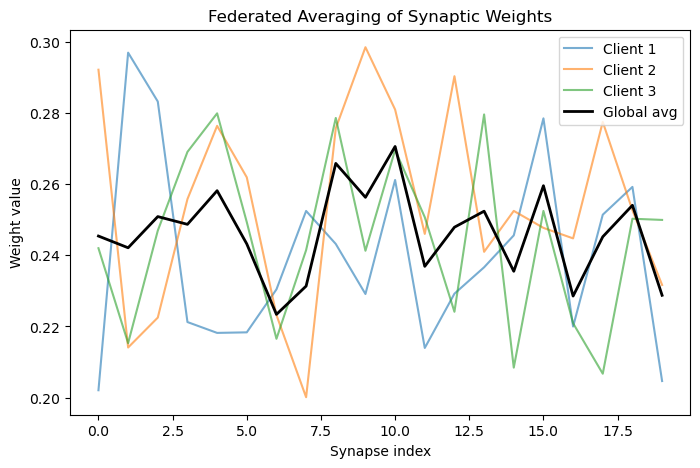

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import time
from brian2 import *

# Ensure reproducibility
np.random.seed(42)
seed(42)

# ===========================
# Helper: run tiny SNN
# ===========================
def run_snn(num_inputs=10, num_outputs=2, sim_time=100*ms):
    start = time.time()
    
    # Poisson input with higher baseline rate
    rates = np.random.uniform(15, 30, num_inputs) * Hz
    inp = PoissonGroup(num_inputs, rates=rates)

    # Simple LIF neurons
    eqs = '''
    dv/dt = (0.2-v)/(10*ms) : 1
    '''
    output = NeuronGroup(num_outputs, eqs, threshold='v>1', reset='v=0', method='euler')

    # FIXED connectivity (all-to-all to keep shape identical)
    S = Synapses(inp, output, 'w : 1', on_pre='v_post += w')
    S.connect()  
    S.w = '0.2 + 0.1*rand()'

    spikemon = SpikeMonitor(output)

    run(sim_time)

    runtime = time.time() - start

    spikes = spikemon.num_spikes
    spike_counts = np.bincount(spikemon.i, minlength=num_outputs)
    active_neurons = (spike_counts > 0).sum()
    sparsity = 1 - active_neurons/num_outputs

    latency = np.mean(spikemon.t/ms) if spikes > 0 else np.nan

    return {
        "weights": S.w[:].copy(),
        "spikes": spikes,
        "latency_ms": latency,
        "sparsity": sparsity,
        "runtime_s": runtime
    }

# ===========================
# Federated Averaging
# ===========================
def federated_average(weights_list):
    return np.mean(np.stack(weights_list), axis=0)

# ===========================
# Simulate Clients + Global
# ===========================
num_clients = 3
results = []
weights_all = []

print("=== Federated Training Round 1 ===")
for i in range(num_clients):
    res = run_snn()
    weights_all.append(res["weights"])
    results.append(res)
    print(f"Client {i+1}: spikes={res['spikes']}, latency={res['latency_ms']:.2f} ms, "
          f"sparsity={res['sparsity']:.2f}, runtime={res['runtime_s']:.3f}s")

# Global averaging
global_w = federated_average(weights_all)
global_metrics = {
    "weights": global_w,
    "spikes": np.mean([r["spikes"] for r in results]),
    "latency_ms": np.nanmean([r["latency_ms"] for r in results]),
    "sparsity": np.mean([r["sparsity"] for r in results]),
    "runtime_s": np.mean([r["runtime_s"] for r in results]),
}
print(f"\nGlobal model (averaged): spikes={global_metrics['spikes']:.1f}, "
      f"latency={global_metrics['latency_ms']:.2f} ms, sparsity={global_metrics['sparsity']:.2f}, "
      f"runtime={global_metrics['runtime_s']:.3f}s")

# ===========================
# Plotting Weights
# ===========================
plt.figure(figsize=(8,5))
for i, w in enumerate(weights_all):
    plt.plot(w, alpha=0.6, label=f'Client {i+1}')
plt.plot(global_w, 'k-', linewidth=2, label="Global avg")
plt.title("Federated Averaging of Synaptic Weights")
plt.xlabel("Synapse index")
plt.ylabel("Weight value")
plt.legend()
plt.show()


WARNING    'w' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value array([0.24199858, 0.21529958, 0.24694268, ..., 0.20670656, 0.25029339,
       0.24995622]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


=== Federated Evaluation Matrix (per round) ===
    round     model  spikes  latency_ms  sparsity  runtime_s
0       1  Client 1       6   51.700000       0.0   0.389681
1       1  Client 2       2   64.000000       0.0   0.361965
2       1  Client 3       0         NaN       1.0   0.369003
3       1    Global       6   64.000000       0.0   0.357035
4       2  Client 1       8   70.650000       0.0   0.356005
5       2  Client 2       4   50.050000       0.0   0.356965
6       2  Client 3       0         NaN       1.0   0.361040
7       2    Global       3   89.100000       0.0   0.356629
8       3  Client 1       4   65.800000       0.0   0.355984
9       3  Client 2       5   49.540000       0.0   0.355656
10      3  Client 3       5   60.520000       0.0   0.353991
11      3    Global       4   47.950000       0.0   0.367007
12      4  Client 1       6   58.133333       0.0   0.392100
13      4  Client 2       2    9.300000       0.0   0.363041
14      4  Client 3       2   36.3000

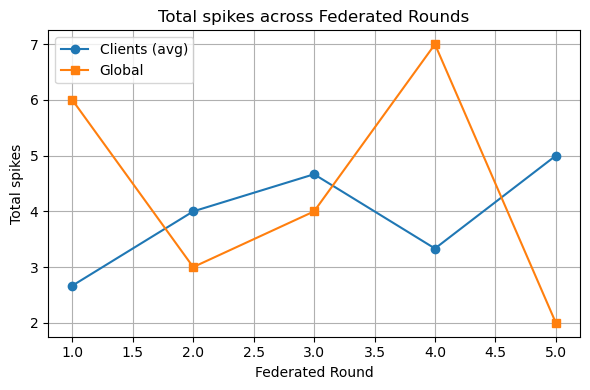

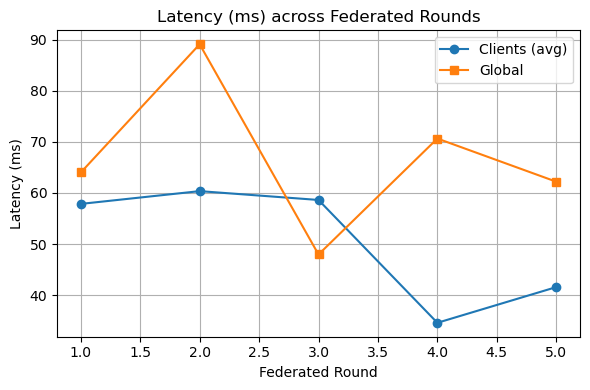

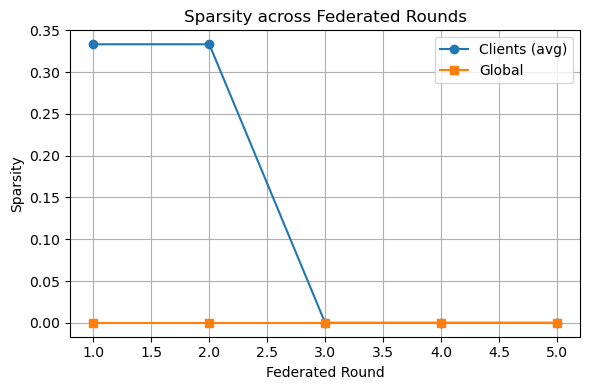

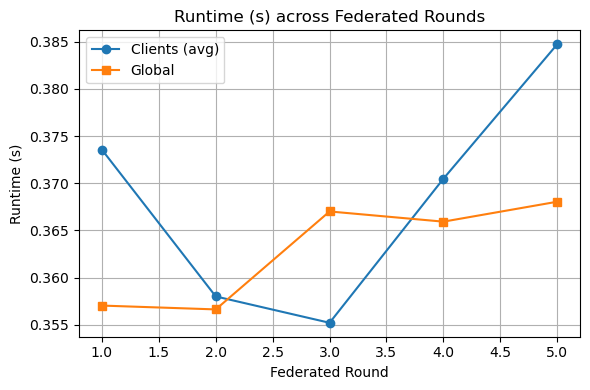

In [40]:


# ---------- Config ----------
np.random.seed(42); seed(42)               # reproducible
NUM_CLIENTS   = 3
NUM_INPUTS    = 10
NUM_OUTPUTS   = 2
SIM_TIME      = 100*ms
ROUNDS        = 5
RATE_MIN_HZ   = 15
RATE_MAX_HZ   = 30

# ---------- Tiny SNN run (with optional weight init) ----------
def run_client_snn(num_inputs=NUM_INPUTS, num_outputs=NUM_OUTPUTS,
                   sim_time=SIM_TIME, init_w=None):
    start_scope()
    # use a different local name to avoid the 'rates' name warning
    rate_vals = np.random.uniform(RATE_MIN_HZ, RATE_MAX_HZ, num_inputs) * Hz
    inp = PoissonGroup(num_inputs, rates=rate_vals)

    eqs = "dv/dt = (0.2 - v) / (10*ms) : 1"
    out = NeuronGroup(num_outputs, eqs, threshold="v>1", reset="v=0", method="euler")

    # all-to-all so synapse count is identical for all clients
    S = Synapses(inp, out, "w : 1", on_pre="v_post += w")
    S.connect()                            # num_inputs * num_outputs synapses
    if init_w is None:
        S.w = "0.2 + 0.1*rand()"
    else:
        S.w = init_w                       # start from global weights

    spk = SpikeMonitor(out)

    t0 = time.time()
    run(sim_time)
    runtime_s = time.time() - t0

    spikes = spk.num_spikes
    counts = np.bincount(spk.i, minlength=num_outputs)
    sparsity = 1.0 - (counts > 0).sum() / num_outputs
    latency_ms = np.mean(spk.t/ms) if spikes > 0 else np.nan

    return {
        "weights": S.w[:].copy(),
        "spikes": spikes,
        "latency_ms": latency_ms,
        "sparsity": sparsity,
        "runtime_s": runtime_s
    }

# ---------- FedAvg ----------
def fedavg(weight_list):
    # all shapes identical: (NUM_INPUTS*NUM_OUTPUTS,)
    return np.mean(np.stack(weight_list), axis=0)

# ---------- Federated rounds ----------
records = []                  # will hold per-round, per-model metrics
global_w = None               # start from random init in round 1

for r in range(1, ROUNDS+1):
    client_weights = []
    client_metrics = []

    # each client trains starting from current global weights
    for c in range(1, NUM_CLIENTS+1):
        res = run_client_snn(init_w=global_w)
        client_weights.append(res["weights"])
        client_metrics.append(res)

        records.append({
            "round": r, "model": f"Client {c}",
            "spikes": res["spikes"],
            "latency_ms": res["latency_ms"],
            "sparsity": res["sparsity"],
            "runtime_s": res["runtime_s"]
        })

    # aggregate → new global
    global_w = fedavg(client_weights)

    # evaluate "global model" by running once with the averaged weights
    global_eval = run_client_snn(init_w=global_w)
    records.append({
        "round": r, "model": "Global",
        "spikes": global_eval["spikes"],
        "latency_ms": global_eval["latency_ms"],
        "sparsity": global_eval["sparsity"],
        "runtime_s": global_eval["runtime_s"]
    })

# tidy results
df_fed = pd.DataFrame(records)
print("=== Federated Evaluation Matrix (per round) ===")
print(df_fed)

# ---------- Plots: Global convergence ----------
def plot_metric(df, metric, ylabel):
    plt.figure(figsize=(6,4))
    # average client metric per round
    m_clients = (df.query("model.str.startswith('Client')", engine="python")
                   .groupby("round")[metric].mean())
    m_global  = (df.query("model == 'Global'").set_index("round")[metric])
    plt.plot(m_clients.index, m_clients.values, marker="o", label="Clients (avg)")
    plt.plot(m_global.index,  m_global.values,  marker="s", label="Global")
    plt.xlabel("Federated Round")
    plt.ylabel(ylabel)
    plt.title("{} across Federated Rounds".format(ylabel))
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plot_metric(df_fed, "spikes",      "Total spikes")
plot_metric(df_fed, "latency_ms",  "Latency (ms)")
plot_metric(df_fed, "sparsity",    "Sparsity")
plot_metric(df_fed, "runtime_s",   "Runtime (s)")
